In [1]:
%matplotlib inline
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,\
        precision_score, recall_score, f1_score, roc_auc_score,auc, \
average_precision_score,precision_recall_curve, \
classification_report, roc_curve,confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


def find_best_threshold(thresholds, fpr, tpr):
    """
    find the best threshold from the roc curve. by finding the threshold for 
    the point which is closest to (fpr=0,tpr=1)
    """
    fpr_tpr = pd.DataFrame({'thresholds': thresholds, 'fpr': fpr, 'tpr': tpr})
    fpr_tpr['dist'] = (fpr_tpr['fpr'])**2 + (fpr_tpr['tpr']-1)**2
    return fpr_tpr.loc[fpr_tpr.dist.idxmin(), 'thresholds']


def get_model_results(model, X_train, X_test, y_train, y_test, title):
    """ gets model,train and test sets with labels
    returns the AUC-ROC plot for train and test sets 
    and classification_report
    
    **Note:** only for binary classification
    """
    #find_best_threshold and predict_proba X_test
    probabilities = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    threshold = find_best_threshold(thresholds, fpr, tpr)
    predictions = probabilities>threshold
    
    fig = plt.figure(figsize = (18,5))
    # calculate precision-recall curve
    precision, recall, thresholds = \
    precision_recall_curve(y_test,probabilities, pos_label=1)
    precision, recall = np.round(precision, 2), np.round(recall, 2)
    # average precision score
    avg_precision = average_precision_score(y_test,probabilities,pos_label=1)
    # precision auc
    pr_auc = auc(recall, precision)
    
    #PR Curve X_Test
    ax1 = plt.subplot(121)
    ax1.plot(recall, precision, lw=1, color='blue', 
             label=f'AP={round(avg_precision,3)}; AUC={round(pr_auc,3)}') 
    plt.fill_between(recall, precision,-1, 
                     facecolor='lightblue', alpha=0.5)
    plt.xlabel('Recall (TPR)')
    plt.ylim(0,1)

    plt.ylabel('Precision')
    plt.legend(loc="best")
    plt.title(f'PR Curve for {title}');

     
    # calculate AUC-ROC curve for X_test
    fpr, tpr, thresholds = roc_curve(y_test,probabilities,pos_label=1)
    roc_auc = auc(fpr, tpr)
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = roc_auc_score(y_test, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

    ax2 = plt.subplot(122)
    ax2.plot(fpr, tpr, lw=1, color='red',
             label=f"AUC-ROC X_Test= {round(roc_auc,4)}") 
    
    # calculate AUC-ROC curve for X_Train
    probabilities_train = model.predict_proba(X_train)[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, probabilities_train)
    
    ax2.plot(fpr, tpr, label='X_Train')
    ax2.plot(ns_fpr, ns_tpr, color='grey',
             linestyle='--', label='Baseline')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc="best")
    plt.title(f'AUC-ROC Curve for {title}');
    
    print(classification_report(y_test, predictions))

**sourse links**:<br>https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/<br>https://www.mikulskibartosz.name/xgboost-hyperparameter-tuning-in-python-using-grid-search/<br>https://mlfromscratch.com/gridsearch-keras-sklearn/#/<br>https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/<br>https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn<br>

#### Download dataSet

In [2]:
df = pickle.load(open('ner.pkl', 'rb'))
df.head()

,Unnamed: 0,Unnamed: 0.1,id,qid1,qid2,question1,question2,is_duplicate,preprocessed_q1,preprocessed_q2,lev_dist,vectorize_q1,vectorize_q2,cos_dist,NER_q1,NER_q2,ner_score
0,0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what step step guide invest share market india,what step step guide invest share market,0.133333,"[0.004021522, -0.064663194, 0.054782487, 0.001...","[0.0032026137, -0.057278365, 0.047676113, -0.0...",0.008950,india,,-1.0
1,1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what story kohinoor koh-i-noor diamond,what would happen indian government stole kohi...,0.800000,"[-0.0025039953, 0.0231002, 0.054980848, 0.0274...","[-0.007604361, 0.0023462633, 0.057481177, 0.02...",0.144193,Kohinoor (Koh-i-Noor) Diamond,Indian|Kohinoor,-1.0
2,2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how increase speed internet connection using vpn,how internet speed increased hacking dns,0.769231,"[0.01574258, -0.0036987886, 0.054218505, 0.005...","[-0.0063505485, -0.0066181184, 0.07119932, 0.0...",0.309832,VPN,DNS,-1.0
3,3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why mentally lonely how solve,find remainder when math 23^ 24 /math divided ...,1.333333,"[0.030234994, 0.011868301, 0.009653048, 0.0044...","[-0.0066201733, -0.0043005846, 0.022001026, 0....",0.499690,,"24,23",-1.0
4,4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolve water quikly sugar salt methane c...,fish would survive salt water,1.200000,"[0.0059792893, -0.017025381, 0.061780103, -0.0...","[0.007501155, -0.03248704, 0.08386232, 0.02480...",0.151050,one|quikly,,-1.0


In [3]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'qid1', 'qid2', 'question1',
       'question2', 'is_duplicate', 'preprocessed_q1', 'preprocessed_q2',
       'lev_dist', 'vectorize_q1', 'vectorize_q2', 'cos_dist', 'NER_q1',
       'NER_q2', 'ner_score'],
      dtype='object')

In [4]:
print("Data set size:", len(df))

Data set size: 404247


#### - Prepare small playground data set (100000 example)

In [5]:
df_sm = df[:100000].copy()
df_train,df_test = train_test_split(df_sm,test_size=0.10)

In [6]:
df_train.shape

(90000, 17)

#### - X_train and X_test for `cos_dist`

In [7]:
X_train = df_train['cos_dist'].copy().to_numpy().reshape(-1, 1)
X_test = df_test['cos_dist'].copy().to_numpy().reshape(-1, 1)

X_train.shape, X_test.shape

((90000, 1), (10000, 1))

#### - y_train and y_test for all the experiments

In [8]:
y_train = df_train['is_duplicate'].copy()
y_test = df_test['is_duplicate'].copy()

y_train.shape,y_test.shape

((90000,), (10000,))

### Search for the best hyper parameters with GridSearchCV

In [9]:
# estimator = XGBClassifier(
#     objective= 'binary:logistic',
#     nthread=4,
#     seed=0
# )


# parameters = {
#         'n_estimators': [100, 150, 200],
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [1, 3, 4, ]
#         }

# grid_search = GridSearchCV(
#     estimator=estimator,
#     param_grid=parameters,
#     scoring = 'recall',
#     n_jobs = 10,
#     verbose=True
# )

# grid_search.fit(X_train,  y_train)


In [10]:

#--------------------------OUTPUT---------------------------------------

# Fitting 5 folds for each of 972 candidates, totalling 4860 fits
# [Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
# [Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   41.3s
# [Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  4.5min
# [Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 13.7min
# [Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 25.0min
# [Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 40.1min
# [Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 56.2min
# [Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 78.5min
# [Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 99.6min
# [Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 127.2min
# [Parallel(n_jobs=10)]: Done 4860 out of 4860 | elapsed: 154.5min finished
# GridSearchCV(cv=None, error_score=nan,
#              estimator=XGBClassifier(base_score=0.5, booster='gbtree',
#                                      colsample_bylevel=1, colsample_bynode=1,
#                                      colsample_bytree=1, gamma=0,
#                                      learning_rate=0.1, max_delta_step=0,
#                                      max_depth=3, min_child_weight=1,
#                                      missing=None, n_estimators=100, n_jobs=1,
#                                      nthread=4, objective='binary:logistic',
#                                      random_state=0, reg_alpha=0, reg_lambda=1,
#                                      scale_pos_weight=1, seed=0, silent=None,
#                                      subsample=1, verbosity=1),
#              iid='deprecated', n_jobs=10,
#              param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
#                          'gamma': [0.5, 1, 2, 5], 'max_depth': [1, 3, 4],
#                          'min_child_weight': [1, 5, 10],
#                          'n_estimators': [100, 150, 200],
#                          'subsample': [0.6, 0.8, 1.0]},
#              pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
#              scoring='recall', verbose=True)

In [11]:
#grid_search.best_estimator_

In [12]:
#--------------------------OUTPUT---------------------------------------

# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
#               learning_rate=0.1, max_delta_step=0, max_depth=1,
#               min_child_weight=5, missing=None, n_estimators=200, n_jobs=1,
#               nthread=4, objective='binary:logistic', random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
#               silent=None, subsample=0.6, verbosity=1)

### - XGBRegressor learned on `cos_dist`


In [13]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=5, missing=None, n_estimators=200, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.6, verbosity=1)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=1, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=0, silent=None, subsample=0.6, tree_method=None,
              validate_parameters=False, verbosity=1)

#### - Here Results for the best AUC-ROC curve `cos_dist`

              precision    recall  f1-score   support

           0       0.71      0.64      0.67      6227
           1       0.49      0.58      0.53      3773

    accuracy                           0.62     10000
   macro avg       0.60      0.61      0.60     10000
weighted avg       0.63      0.62      0.62     10000



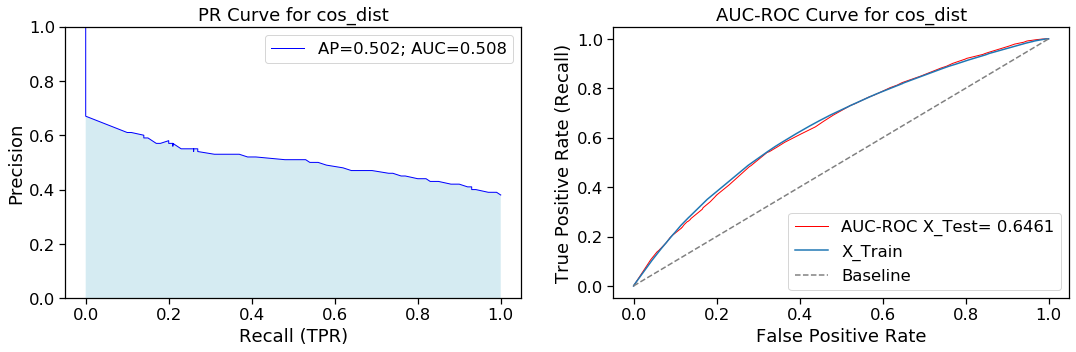

In [14]:
get_model_results(model, X_train, X_test, y_train, y_test, 'cos_dist')

#### Not very impressive ಠ_ಠ

### Let's try XGBClassifier with other features: `cos_dist`, and `ner_score`:

In [15]:
X_train_2 = df_train[['cos_dist', 'ner_score']].copy()
X_test_2 = df_test[['cos_dist', 'ner_score']].copy()

X_train_2.shape, X_test_2.shape

((90000, 2), (10000, 2))

In [16]:
model2 =  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=5, missing=None, n_estimators=200, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.6, verbosity=1)
model2.fit(X_train_2, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=1, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=0, silent=None, subsample=0.6, tree_method=None,
              validate_parameters=False, verbosity=1)

#### - Here Results for the best AUC-ROC curve `cos_dist`, and `ner_score`

              precision    recall  f1-score   support

           0       0.74      0.65      0.69      6227
           1       0.52      0.61      0.56      3773

    accuracy                           0.64     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.65      0.64      0.64     10000



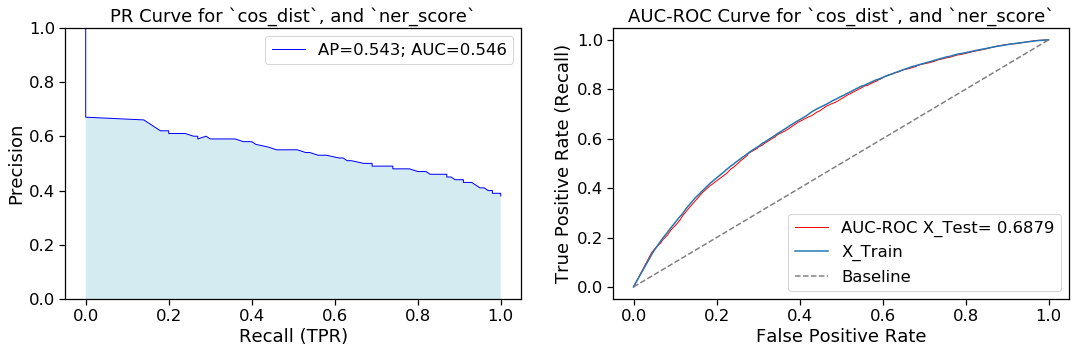

In [17]:
get_model_results(model2, X_train_2, X_test_2, y_train, y_test, 
                  '`cos_dist`, and `ner_score`')

#### This result is better for now, but also not so good (>ლ)


### - XGBClassifier learned on FastText's vectors

In [18]:
X_train_3 = np.concatenate((np.stack(df_train['vectorize_q1'].to_numpy(), axis=0),\
                          np.stack(df_train['vectorize_q2'].to_numpy(), axis=0)),
                         axis=1)

X_test_3 = np.concatenate((np.stack(df_test['vectorize_q1'].to_numpy(), axis=0),\
                          np.stack(df_test['vectorize_q2'].to_numpy(), axis=0)), 
                        axis=1)
X_train_3.shape, X_test_3.shape

((90000, 600), (10000, 600))

In [19]:
model3 =  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=5, missing=None, n_estimators=200, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.6, verbosity=1)
model3.fit(X_train_3, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=1, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=0, silent=None, subsample=0.6, tree_method=None,
              validate_parameters=False, verbosity=1)

              precision    recall  f1-score   support

           0       0.75      0.66      0.71      6227
           1       0.54      0.64      0.58      3773

    accuracy                           0.66     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.67      0.66      0.66     10000



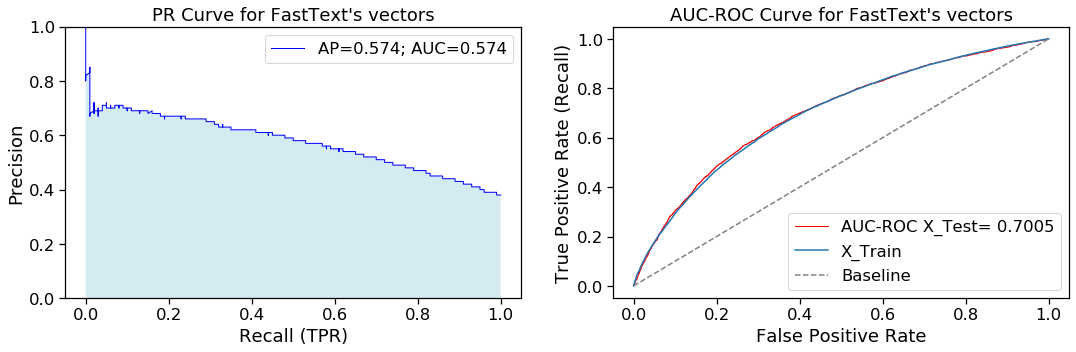

In [20]:
get_model_results(model3, X_train_3, X_test_3, y_train, y_test, 
                  "FastText's vectors")

#### On `FastText's vectors` features  we got the higher accuracy score and recall